In [ ]:
# Requiered imports
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


# 1. Dataset Description

The dataset amazon.csv from Kaggle (https://www.kaggle.com/datasets/mahmudulhaqueshawon/amazon-product-reviews) contains customer reviews from Amazon, along with a sentiment label for each review. It consists of approximately 20,000 entries, with two columns: Text (the review content) and label (the sentiment, where 1 typically represents positive and 0 represents negative).

In [88]:
# Load the dataset
df = pd.read_csv('../data/amazon.csv')

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    19996 non-null  object
 1   label   19996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


# 2. Text Pre-Processing

In [90]:
# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [91]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text) # Keep square brackets for now, will remove if needed later.
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(processed_tokens)

In [92]:
# Apply preprocessing
df['processed_text'] = df['Text'].apply(preprocess_text)

# 3. Data Exploration 

### a. Sentiment Distribution
The initial sentiment distribution in the dataset is as follows:

In [93]:
# Sentiment Distribution Analysis
sentiment_counts = df["label"].value_counts()

# Map numerical labels to sentiment names for better readability
sentiment_mapping = {1: "Positive", 0: "Negative"}
df["sentiment"] = df["label"].map(sentiment_mapping)
sentiment_counts_named = df["sentiment"].value_counts()
print(sentiment_counts_named)


sentiment
Positive    15230
Negative     4766
Name: count, dtype: int64


This indicates a significant imbalance, with a much larger number of positive reviews compared to negative ones.

### b. Visualizations

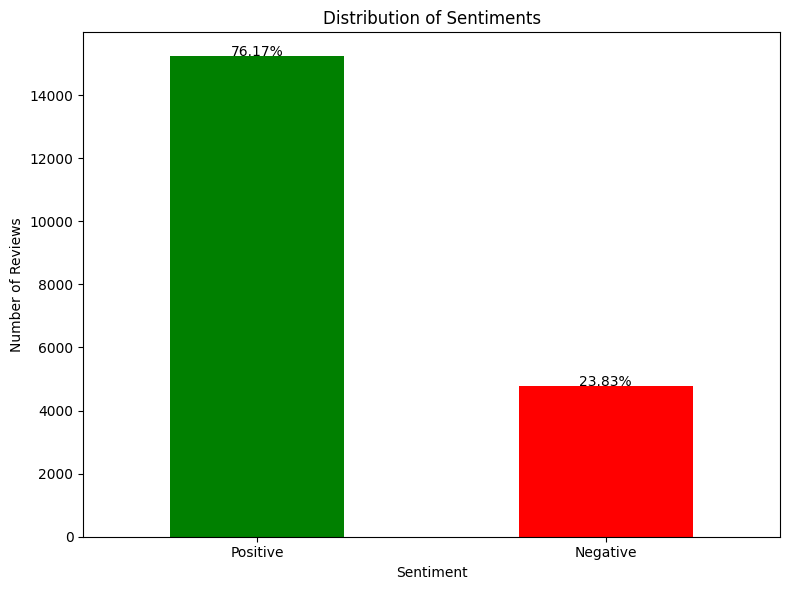

In [94]:
# Sentiment Distribution bar chart
plt.figure(figsize=(8, 6))
sentiment_counts_named.plot(kind="bar", color=["green", "red"])
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()

# Sentiment Distribution Percentages

for i, count in enumerate(sentiment_counts_named):
    plt.text(i, count, f"{(count / len(df) * 100):.2f}%", ha='center')


### c. Insights from data exploration
- The dataset is heavily skewed towards positive reviews, which is common in many product review datasets. This imbalance needs to be considered during model training and evaluation.

# 4. Sentiment Analysis

- **Lexicon based method**

In [95]:
nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()

df["vader_prediction"] = df["processed_text"].apply(lambda x: sid.polarity_scores(x))
df["vader_prediction"].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\57317\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0    {'neg': 0.153, 'neu': 0.526, 'pos': 0.321, 'co...
1    {'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'comp...
2    {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'comp...
3    {'neg': 0.154, 'neu': 0.16, 'pos': 0.686, 'com...
4    {'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...
Name: vader_prediction, dtype: object

In [96]:
# Filter out neutral predictions for comparison with binary labels (1:Positive, 0:Negative)
def vader_to_binary(scores):
    if scores["compound"] >= 0.05:
        return 1  # Positive
    elif scores["compound"] <= -0.05:
        return 0  # Negative
    else:
        return 2  # Neutral

df["vader_binary"] = df["vader_prediction"].apply(vader_to_binary)
vader_accuracy = accuracy_score(df["label"], df["vader_binary"])
print(f"VADER Accuracy (excluding neutral): {vader_accuracy:.4f}")
print("VADER Classification Report (excluding neutral):\n", classification_report(df["label"], df["vader_binary"], labels=[0, 1], target_names=["Negative", "Positive"]))

VADER Accuracy (excluding neutral): 0.7846
VADER Classification Report (excluding neutral):
               precision    recall  f1-score   support

    Negative       0.65      0.43      0.51      4766
    Positive       0.86      0.90      0.88     15230

   micro avg       0.82      0.78      0.80     19996
   macro avg       0.75      0.66      0.70     19996
weighted avg       0.81      0.78      0.79     19996



- **Naive Bayes**

In [97]:
# Prepare data for ML model
X = df["processed_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000) # Limit features to manage complexity
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [99]:
# model training
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [100]:
# Predict and evaluate
nb_predictions = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions, labels=[0, 1], target_names=["Negative", "Positive"]))

Naive Bayes Accuracy: 0.8528
Naive Bayes Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.44      0.59       978
    Positive       0.84      0.99      0.91      3022

    accuracy                           0.85      4000
   macro avg       0.88      0.71      0.75      4000
weighted avg       0.86      0.85      0.83      4000



# 5. Analysis and Visualization

### a. Overal Sentiment Distribution

In [101]:

print("\n--- Overall Sentiment Distribution (VADER Predictions) ---")
sentiment_mapping = {1: "Positive", 0: "Negative", 2: "Neutral"}
df["vader_sentiment"] = df["vader_binary"].map(sentiment_mapping)
sentiment_distribution = df["vader_sentiment"].value_counts()
print(sentiment_distribution)


--- Overall Sentiment Distribution (VADER Predictions) ---
vader_sentiment
Positive    15952
Negative     3144
Neutral       900
Name: count, dtype: int64


### b. Bigrams and Trigrams

In [102]:
# Bigrams and Trigrams

def get_ngrams(text_series, n):
    all_ngrams = []
    for text in text_series.dropna():
        tokens = text.split()
        all_ngrams.extend(list(ngrams(tokens, n)))
    return [" ".join(ngram) for ngram in all_ngrams]


In [103]:
# Filter for positive and negative reviews based on VADER predictions
positive_reviews_text = df[df["vader_binary"] == 1]["processed_text"]
negative_reviews_text = df[df["vader_binary"] == 0]["processed_text"]

In [104]:
print("\n--- Most Frequent Bigrams (Positive Reviews) ---")
positive_bigrams = get_ngrams(positive_reviews_text, 2)
positive_bigram_counts = Counter(positive_bigrams)
print(positive_bigram_counts.most_common(10))


--- Most Frequent Bigrams (Positive Reviews) ---
[('kindle fire', 1183), ('easy use', 740), ('love app', 633), ('work great', 515), ('great app', 513), ('love game', 383), ('free app', 335), ('would recommend', 278), ('work well', 277), ('really like', 274)]


In [105]:
print("\n--- Most Frequent Trigrams (Positive Reviews) ---")
positive_trigrams = get_ngrams(positive_reviews_text, 3)
positive_trigram_counts = Counter(positive_trigrams)
print(positive_trigram_counts.most_common(10))


--- Most Frequent Trigrams (Positive Reviews) ---
[('kindle fire hd', 146), ('great kindle fire', 130), ('free app day', 129), ('work great kindle', 106), ('app kindle fire', 96), ('app easy use', 87), ('app work great', 81), ('would recommend anyone', 66), ('fun fun fun', 54), ('really like app', 51)]


In [106]:
print("\n--- Most Frequent Bigrams (Negative Reviews) ---")
negative_bigrams = get_ngrams(negative_reviews_text, 2)
negative_bigram_counts = Counter(negative_bigrams)
print(negative_bigram_counts.most_common(10))


--- Most Frequent Bigrams (Negative Reviews) ---
[('kindle fire', 445), ('dont get', 159), ('waste time', 137), ('get app', 116), ('alarm clock', 86), ('angry bird', 82), ('task killer', 56), ('dont know', 52), ('doesnt work', 51), ('fire hd', 49)]


In [107]:
print("\n--- Most Frequent Trigrams (Negative Reviews) ---")
negative_trigrams = get_ngrams(negative_reviews_text, 3)
negative_trigram_counts = Counter(negative_trigrams)
print(negative_trigram_counts.most_common(10))


--- Most Frequent Trigrams (Negative Reviews) ---
[('kindle fire hd', 49), ('dont get app', 39), ('work kindle fire', 31), ('app kindle fire', 27), ('worst app ever', 26), ('dont waste time', 21), ('worst game ever', 17), ('boring boring boring', 14), ('bang bang bang', 13), ('use kindle fire', 12)]


### c. Sentiment Distribution Visualization (Vader)

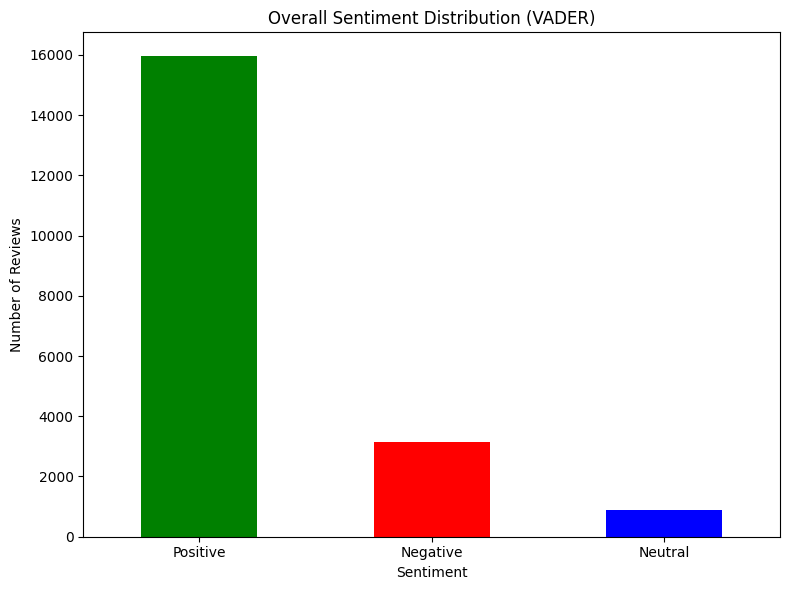

In [108]:
# Visualize Overall Sentiment Distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind="bar", color=["green", "red", "blue"])
plt.title("Overall Sentiment Distribution (VADER)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()